In [8]:
import xarray as xr
import schwabdev as sd
import json
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time
import calendar
import time as tm

from universes.universe_config import Universe_Config as uc

def create_client():
    """Create a Schwab client with API keys."""
    with open('keys.json', 'r') as f:
        keys = json.load(f)

    return sd.Client(keys['schwab']['app_key'], keys['schwab']['app_secret'])

client = create_client()

In [29]:
YEAR = 2025
MONTH = 1

start_date = f"{YEAR}-{0 if MONTH < 10 else ""}{MONTH}-01"
end_date = f"{YEAR}-{0 if MONTH < 10 else ""}{MONTH}-{calendar.monthrange(YEAR,MONTH)[1]}"

date_format = "%Y-%m-%d"
start_datetime = datetime.strptime(start_date,date_format)
end_datetime = datetime.strptime(end_date,date_format)
tickers = uc.return_universe("u00") + ["F"]
print(len(tickers))

date_diff = date.fromisoformat(end_date) - date.fromisoformat(start_date)
dates_list = [date.fromisoformat(start_date) + timedelta(days=i) for i in range(date_diff.days + 1)]
times_list = [time(hour=(i//4), minute=(i*15)%60) for i in range(48)]

78


In [30]:
all_dfs = []
for ticker in tickers:
    hist = client.price_history(ticker, periodType=None, period=None, frequencyType='minute', frequency=30, startDate=start_datetime,
                      endDate=end_datetime, needExtendedHoursData=True, needPreviousClose=True)
    df = pd.DataFrame(hist.json()['candles'])
    df['datetime'] = pd.to_datetime(df['datetime'],unit="ms",utc=True).map(lambda x: x.tz_convert("America/new_York"))
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.time
    df['ticker'] = ticker
    all_dfs.append(df)
    tm.sleep(0.15)
    print(ticker)


VIGL
BRY
AISP
ALDX
CRDF
AGEN
OIS
EB
ABEO
OSS
OSUR
GSIT
AMPY
BYND
EGY
AIRS
BLDE
OPRT
ANNX
CDLX
ACCO
BDTX
BEEM
DMAC
SLQT
SSP
SEAT
HYLN
WTI
CTKB
UIS
HRTX
NKTX
BIGC
DBI
TLS
SVRA
CDXS
HCAT
EXFY
SPWR
LRMR
BRBS
HLLY
VYGR
AMTX
DOUG
HAIN
VNDA
ELDN
HYMC
AXTI
ARAY
OABI
SIDU
OXSQ
AVIR
EGHT
LUNG
DENN
ACRS
STXS
MGX
MAIA
BWEN
MXCT
CERS
PSQH
CURV
DCGO
UHG
ZNTL
FTFT
MYO
OCC
XELB
SINT
F


In [35]:
combined_df = pd.concat(all_dfs,ignore_index=True)
combined_df = combined_df.set_index(['ticker','date','time'])
ds = combined_df.to_xarray()

In [36]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:   (ticker: 78, date: 26, time: 48)
Coordinates:
  * ticker    (ticker) object 624B 'ABEO' 'ACCO' 'ACRS' ... 'WTI' 'XELB' 'ZNTL'
  * date      (date) object 208B 2025-01-01 2025-01-02 ... 2025-01-30 2025-01-31
  * time      (time) object 384B 00:00:00 00:30:00 ... 23:00:00 23:30:00
Data variables:
    open      (ticker, date, time) float64 779kB nan nan nan nan ... nan nan nan
    high      (ticker, date, time) float64 779kB nan nan nan nan ... nan nan nan
    low       (ticker, date, time) float64 779kB nan nan nan nan ... nan nan nan
    close     (ticker, date, time) float64 779kB nan nan nan nan ... nan nan nan
    volume    (ticker, date, time) float64 779kB nan nan nan nan ... nan nan nan
    datetime  (ticker, date, time) object 779kB NaT NaT NaT NaT ... NaT NaT NaT

In [49]:
ds.sel(ticker='F',date=pd.Timestamp("2025-01-02").date())['volume']

<xarray.DataArray 'volume' (time: 48)> Size: 384B
array([9.800000e+01, 7.430000e+02, 1.390000e+02, 1.468000e+03,
       5.000000e+01, 2.670000e+02, 2.532000e+03, 1.752000e+03,
       3.231700e+04, 3.693000e+03, 8.470000e+02, 1.519000e+03,
       3.928000e+03, 1.522600e+04, 1.577300e+04, 2.519000e+03,
       3.713000e+04, 6.070400e+04, 1.889020e+05, 3.969011e+06,
       3.921013e+06, 4.089426e+06, 3.865224e+06, 3.510458e+06,
       3.879506e+06, 5.541747e+06, 4.234658e+06, 4.140809e+06,
       3.034273e+06, 3.854410e+06, 2.983559e+06, 1.041628e+07,
       4.660440e+06, 8.077700e+04, 2.207500e+04, 3.359200e+04,
       1.959700e+04, 2.604700e+04, 1.111760e+05, 5.988600e+04,
       7.371000e+03, 5.201000e+03, 7.834000e+03, 1.514000e+03,
       1.392000e+03, 4.117000e+03, 1.191000e+03, 6.930000e+02])
Coordinates:
    ticker   <U1 4B 'F'
    date     object 8B 2025-01-02
  * time     (time) object 384B 00:00:00 00:30:00 01:00:00 ... 23:00:00 23:30:00

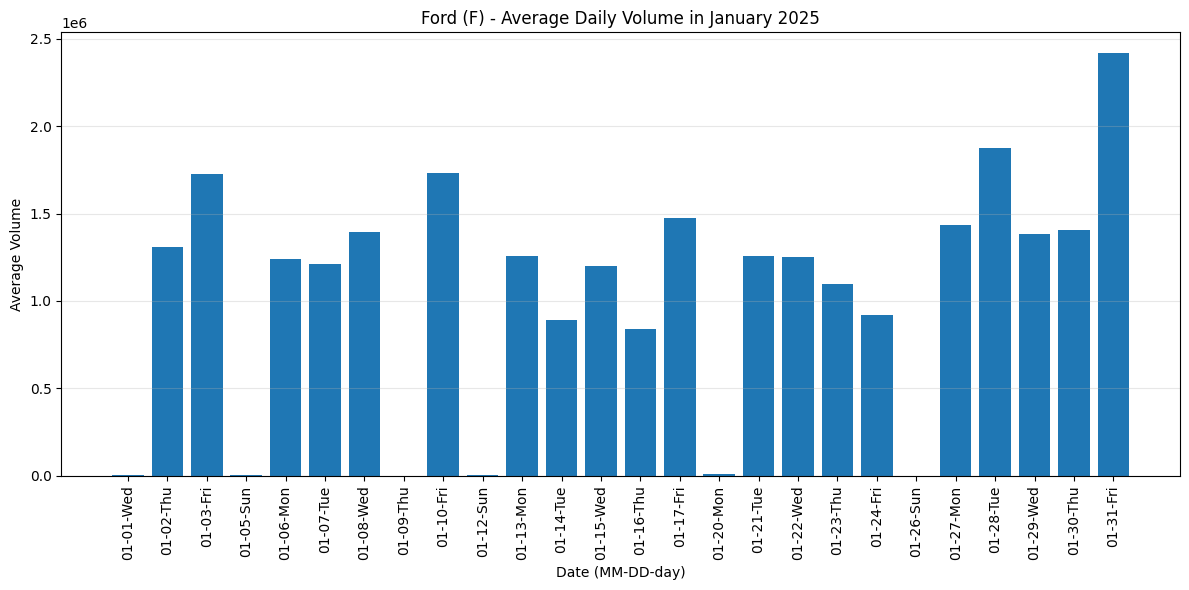

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Get all February dates for ticker 'F'
feb_dates = pd.date_range('2025-01-01', '2025-01-31', freq='D')

# Calculate average volume for each day
daily_avg_volumes = []
dates_with_data = []

for date in feb_dates:
    try:
        # Get volume data for this date
        daily_volume = ds.sel(ticker='F', date=date.date())['volume']
        
        # Calculate average volume for the day (across all times)
        avg_volume = daily_volume.mean().item()  # .item() converts from numpy scalar
        
        daily_avg_volumes.append(avg_volume)
        dates_with_data.append(date)
    except KeyError:
        # Skip if no data for this date (weekends, holidays, etc.)
        continue

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(dates_with_data)), daily_avg_volumes)

# Format x-axis with dates
plt.xticks(range(len(dates_with_data)), 
           [date.strftime('%m-%d-%a') for date in dates_with_data], 
           rotation=90)

plt.xlabel('Date (MM-DD-day)')
plt.ylabel('Average Volume')
plt.title('Ford (F) - Average Daily Volume in January 2025')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()